--- Analyzing Distribution of Pair-Creatable Data Papers ---

--- Summary Statistics for Pair-Creatable Data Papers ---
ペア作成が可能なデータ論文の総数: 2,305

[Distribution of Citing Paper Counts (for this group)]


count    2305.000000
mean        4.204338
std         6.825922
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       197.000000
Name: citing_paper_count, dtype: float64


[Histogram of the Distribution]


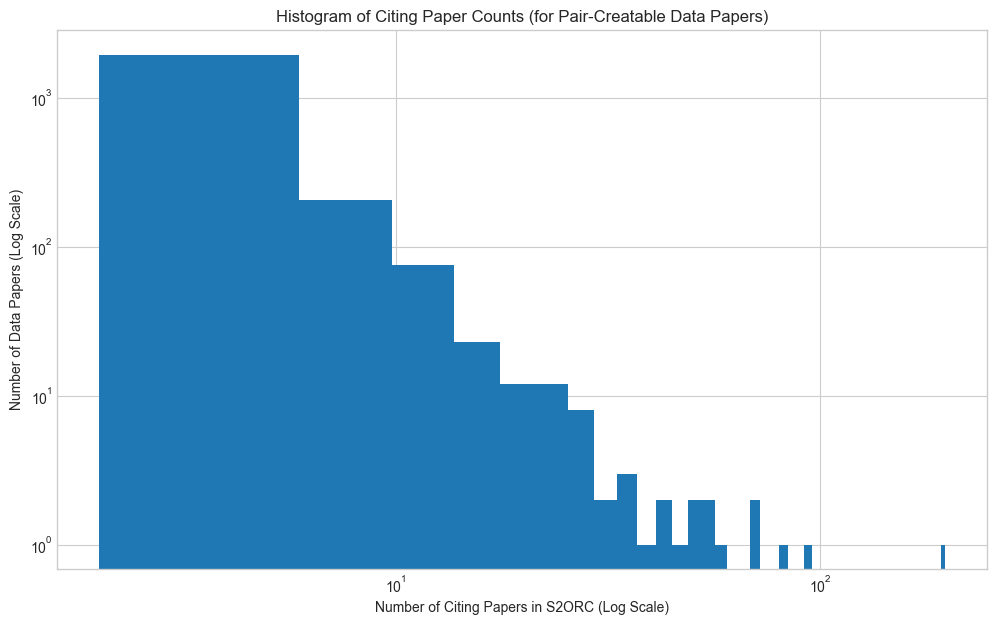

In [2]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_pair_creatable_distribution():
    """
    positive_candidatesから、ペア作成が可能なデータ論文のみを対象に、
    その被引用数分布を調査・可視化する。
    """
    print("--- Analyzing Distribution of Pair-Creatable Data Papers ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # テーブルの存在を確認
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='positive_candidates'")
            if cursor.fetchone() is None:
                print("⚠️ `positive_candidates` table not found.")
                return

            # --- 2.1: ペア作成可能なデータ論文の被引用数を集計 ---
            # HAVING句を使って、引用論文が2件以上のデータ論文のみに絞り込む
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS citing_paper_count
                FROM
                    positive_candidates
                GROUP BY
                    cited_datapaper_doi
                HAVING
                    COUNT(citing_doi) >= 2;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            if df_counts.empty:
                print("No data papers found with 2 or more citing papers.")
                return

            # --- 2.2: 主要な統計情報を表示 ---
            print("\n--- Summary Statistics for Pair-Creatable Data Papers ---")
            print(f"ペア作成が可能なデータ論文の総数: {len(df_counts):,}")
            
            print("\n[Distribution of Citing Paper Counts (for this group)]")
            display(df_counts['citing_paper_count'].describe())

            # --- 2.3: 分布をヒストグラムで可視化 ---
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(12, 7))
            
            # データがまだ偏っている可能性を考慮し、対数スケールを使用
            plt.hist(df_counts['citing_paper_count'], bins=50, log=True)
            
            plt.title('Histogram of Citing Paper Counts (for Pair-Creatable Data Papers)')
            plt.xlabel('Number of Citing Papers in S2ORC (Log Scale)')
            plt.ylabel('Number of Data Papers (Log Scale)')
            plt.xscale('log')
            
            print("\n[Histogram of the Distribution]")
            plt.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_pair_creatable_distribution()

In [3]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_top_quartile():
    """
    ペア作成可能なデータ論文のうち、上位25%の階層を詳しく分析する。
    """
    print("--- Analyzing the Top 25% Stratum of Pair-Creatable Data Papers ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 1. ペア作成可能なデータ論文の被引用数を集計
            query = """
                SELECT cited_datapaper_doi, COUNT(citing_doi) AS citing_paper_count
                FROM positive_candidates
                GROUP BY cited_datapaper_doi
                HAVING COUNT(citing_doi) >= 2;
            """
            df_eligible = pd.read_sql_query(query, conn)
            
            if df_eligible.empty:
                print("No data papers found with 2 or more citing papers.")
                return

            # 2. 四分位数を計算して、上位25%の境界値を取得
            quartiles = df_eligible['citing_paper_count'].quantile([0.25, 0.50, 0.75])
            q75_threshold = quartiles[0.75]
            
            print(f"Quartile boundaries: 25%={quartiles[0.25]}, 50%={quartiles[0.50]}, 75%={q75_threshold}")

            # 3. 上位25%の階層（Stratum 4）のデータのみを抽出
            df_top_quartile = df_eligible[df_eligible['citing_paper_count'] > q75_threshold].copy()

            # --- 3. 結果の報告 ---
            print("\n" + "="*50)
            print("--- Top 25% Stratum Analysis ---")
            print(f"Threshold for Top 25%: > {int(q75_threshold)} citing papers in S2ORC")
            print(f"Number of data papers in this stratum: {len(df_top_quartile):,}")
            
            if not df_top_quartile.empty:
                print("\n[Descriptive Statistics for the Top 25% Stratum]")
                display(df_top_quartile['citing_paper_count'].describe())

                print("\n[Detailed Breakdown of Citing Paper Counts in this Stratum]")
                # この階層内で、具体的に何件の引用を持つ論文がいくつあるかを表示
                display(df_top_quartile['citing_paper_count'].value_counts().sort_index().to_frame("Number of Data Papers"))
                
                print("\n[Sample of Data Papers in the Top 25% Stratum]")
                # papersテーブルと結合してタイトルも表示
                top_dois = df_top_quartile.nlargest(5, 'citing_paper_count')['cited_datapaper_doi'].tolist()
                placeholders = ','.join('?' for _ in top_dois)
                query_titles = f"SELECT doi, title FROM papers WHERE doi IN ({placeholders})"
                df_papers_info = pd.read_sql_query(query_titles, conn, params=top_dois)
                
                df_sample_details = pd.merge(df_top_quartile, df_papers_info, left_on='cited_datapaper_doi', right_on='doi')
                display(df_sample_details.nlargest(5, 'citing_paper_count')[['cited_datapaper_doi', 'title', 'citing_paper_count']])


    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_top_quartile()

--- Analyzing the Top 25% Stratum of Pair-Creatable Data Papers ---
Quartile boundaries: 25%=2.0, 50%=3.0, 75%=4.0

--- Top 25% Stratum Analysis ---
Threshold for Top 25%: > 4 citing papers in S2ORC
Number of data papers in this stratum: 481

[Descriptive Statistics for the Top 25% Stratum]


count    481.000000
mean      10.592516
std       13.039214
min        5.000000
25%        5.000000
50%        7.000000
75%       11.000000
max      197.000000
Name: citing_paper_count, dtype: float64


[Detailed Breakdown of Citing Paper Counts in this Stratum]


,Number of Data Papers
citing_paper_count,
5,125
6,97
7,48
8,36
9,26
10,22
11,22
12,16
13,15



[Sample of Data Papers in the Top 25% Stratum]


,cited_datapaper_doi,title,citing_paper_count
2,10.1038/S41597-020-0453-3,Version 4 of the CRU TS monthly high-resolutio...,197
4,10.5194/ESSD-13-4349-2021,ERA5-Land: A state-of-the-art global reanalysi...,92
3,10.1038/S41597-020-0534-3,The FLUXNET2015 dataset and the ONEFlux proces...,81
0,10.1007/S11558-019-09344-2,The KOF Globalisation Index -revisited,69
1,10.1016/J.DIB.2020.105340,Application of the ARIMA model on the COVID- 2...,69
